In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
!pip install xgboost

In [3]:
df = pd.read_csv('dataset/PJME_hourly.csv')
df = df.set_index('Datetime')

In [4]:
df.index = pd.to_datetime(df.index)

<Axes: title={'center': 'PJME Energy Consumtions in MW'}, xlabel='Datetime'>

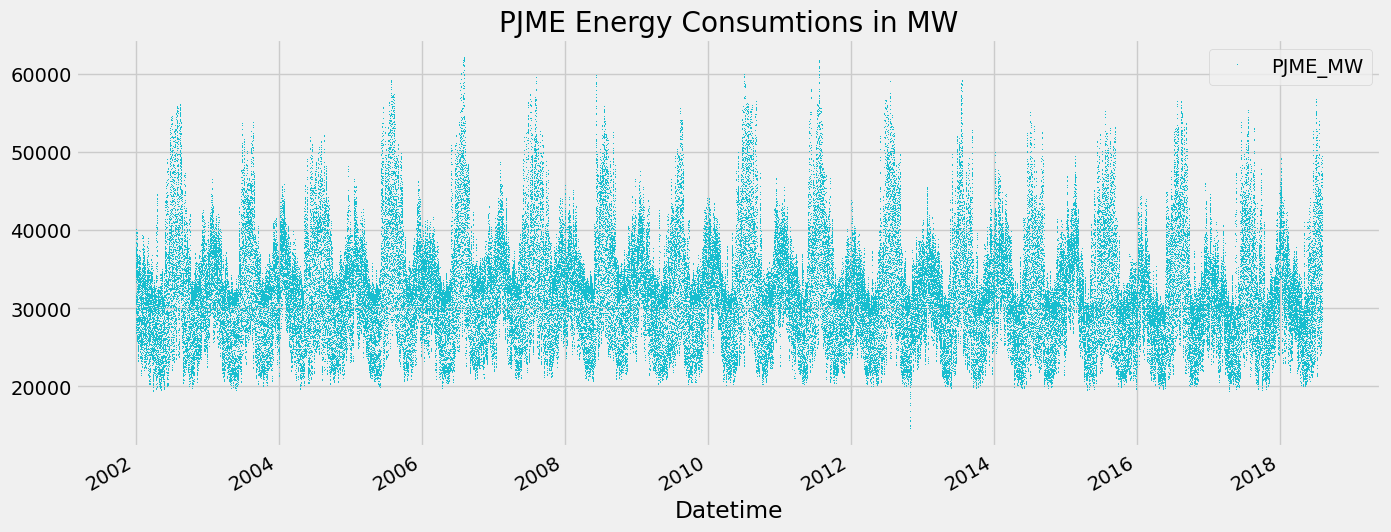

In [5]:
df.plot(style=',', 
        figsize=(15,6), 
        color = color_pal[9], 
        title = 'PJME Energy Consumtions in MW')

#### Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

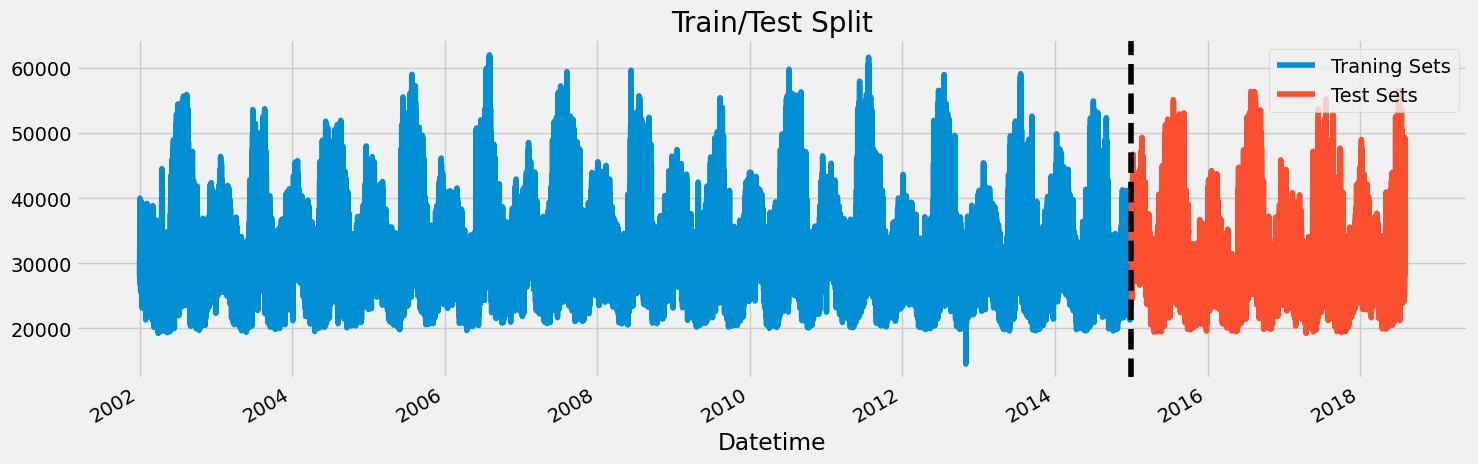

In [7]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(16,5))
train.plot(ax=ax, label='Training Sets', title = 'Train/Test Split')
test.plot(ax=ax, label = 'Test Sets')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Traning Sets', 'Test Sets'])
plt.show()

<Axes: xlabel='Datetime'>

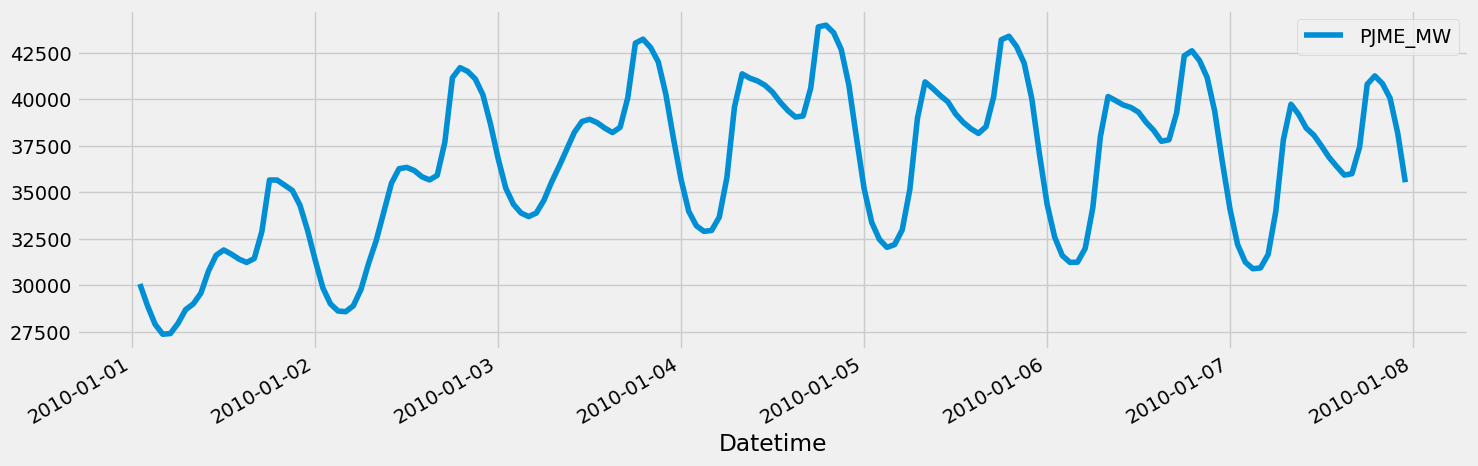

In [8]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(16,5))

#### Feature Creation

In [9]:
def create_features(df):
    '''
    Create Time Series Features
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [10]:
df = create_features(df)

In [11]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


##### Visualize Feature / Targer Relationship

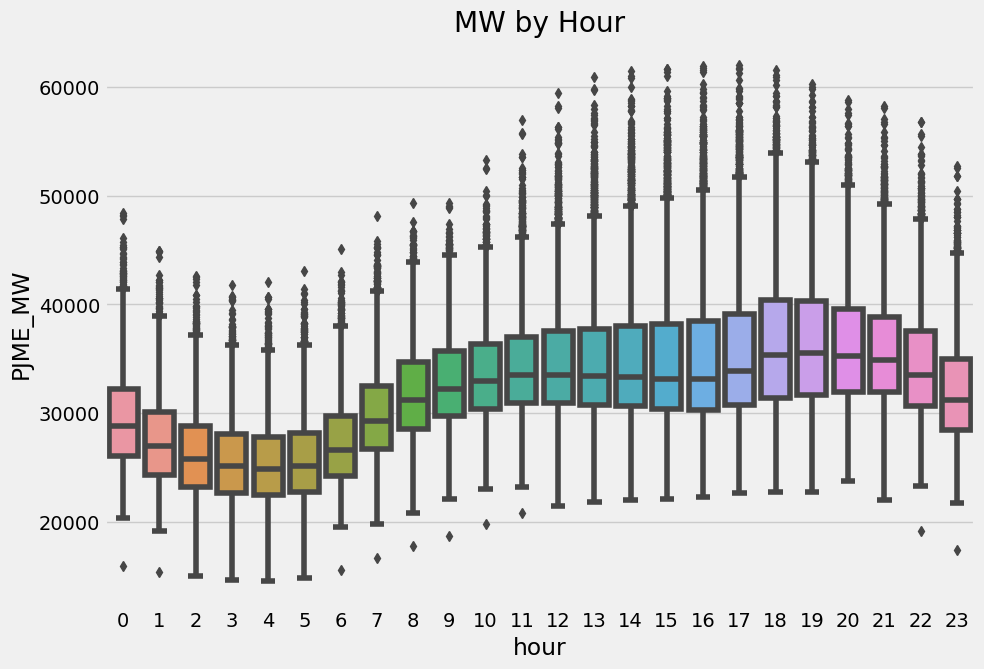

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(data = df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

In [13]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

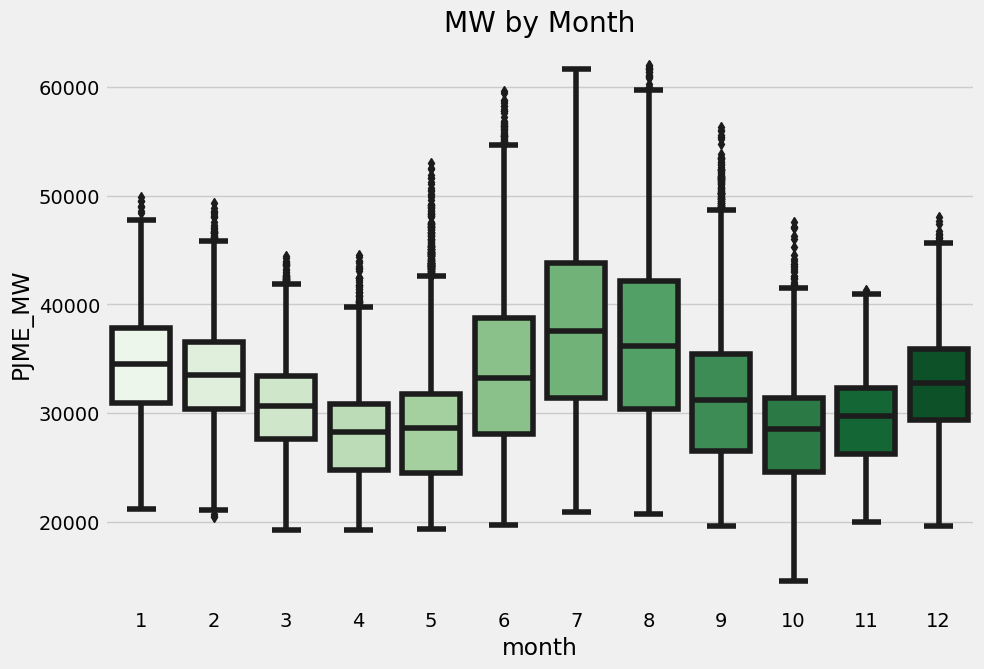

In [14]:
fig,ax = plt.subplots(figsize=(10,7))
sns.boxplot(data=df, x='month', y='PJME_MW', palette = 'Greens')
ax.set_title('MW by Month')
plt.show()

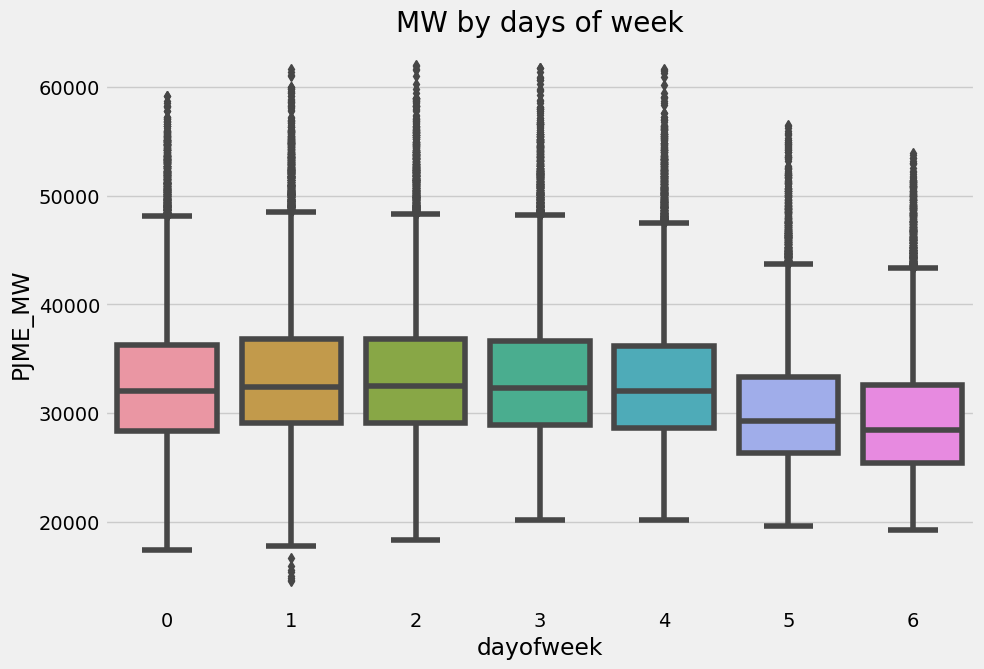

In [15]:
fig,ax = plt.subplots(figsize = (10,7))
sns.boxplot(data=df, x='dayofweek', y='PJME_MW')
ax.set_title('MW by days of week')
plt.show()

#### Create Model

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [18]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [19]:
x_train = train[FEATURES]
y_train = train[TARGET]

x_test = test[FEATURES]
y_test = test[TARGET]

In [20]:
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50,
                       learning_rate = 0.1)
reg.fit(x_train, y_train, 
        eval_set = [(x_train,y_train), (x_test,y_test)],
        verbose = 10)

[0]	validation_0-rmse:29676.17870	validation_1-rmse:28732.06789
[10]	validation_0-rmse:10814.35756	validation_1-rmse:10064.92295
[20]	validation_0-rmse:4751.08180	validation_1-rmse:4684.97917
[30]	validation_0-rmse:3205.16281	validation_1-rmse:3781.33073
[40]	validation_0-rmse:2816.34201	validation_1-rmse:3745.28049
[50]	validation_0-rmse:2667.97890	validation_1-rmse:3773.86040
[60]	validation_0-rmse:2585.20565	validation_1-rmse:3831.26219
[70]	validation_0-rmse:2490.63649	validation_1-rmse:3871.44232
[80]	validation_0-rmse:2415.34722	validation_1-rmse:3900.38917
[83]	validation_0-rmse:2393.51173	validation_1-rmse:3918.46634


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

##### Feature Importance

In [21]:
f1 = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

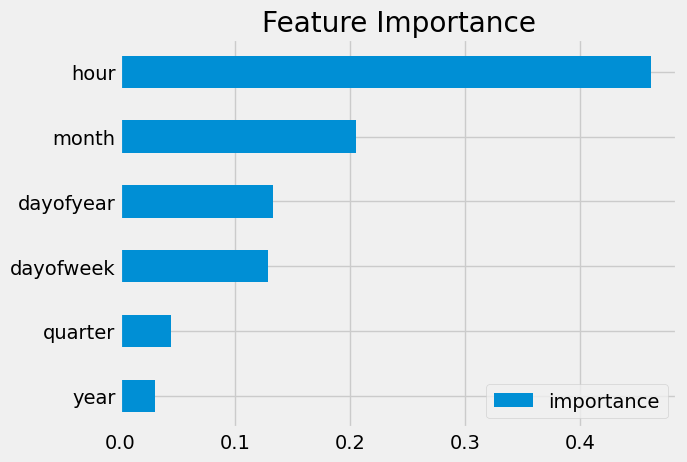

In [22]:
f1.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Forecast on Test

In [23]:
test['prediction'] = reg.predict(x_test)

In [24]:
df = df.merge(test[['prediction']], how='left', left_index = True, right_index = True)

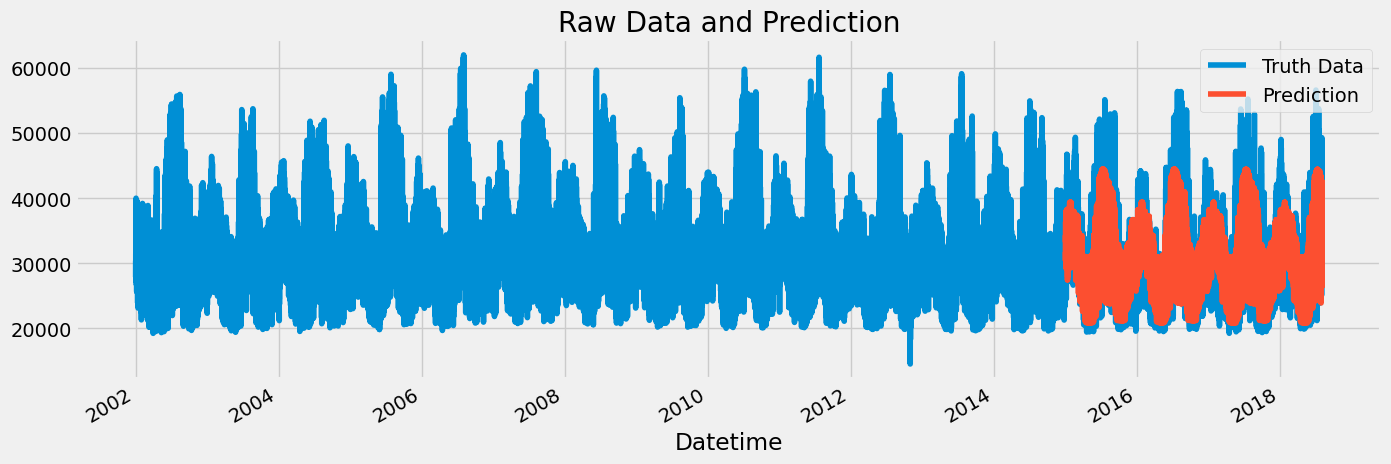

In [25]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df[['prediction']].plot(ax=ax)
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

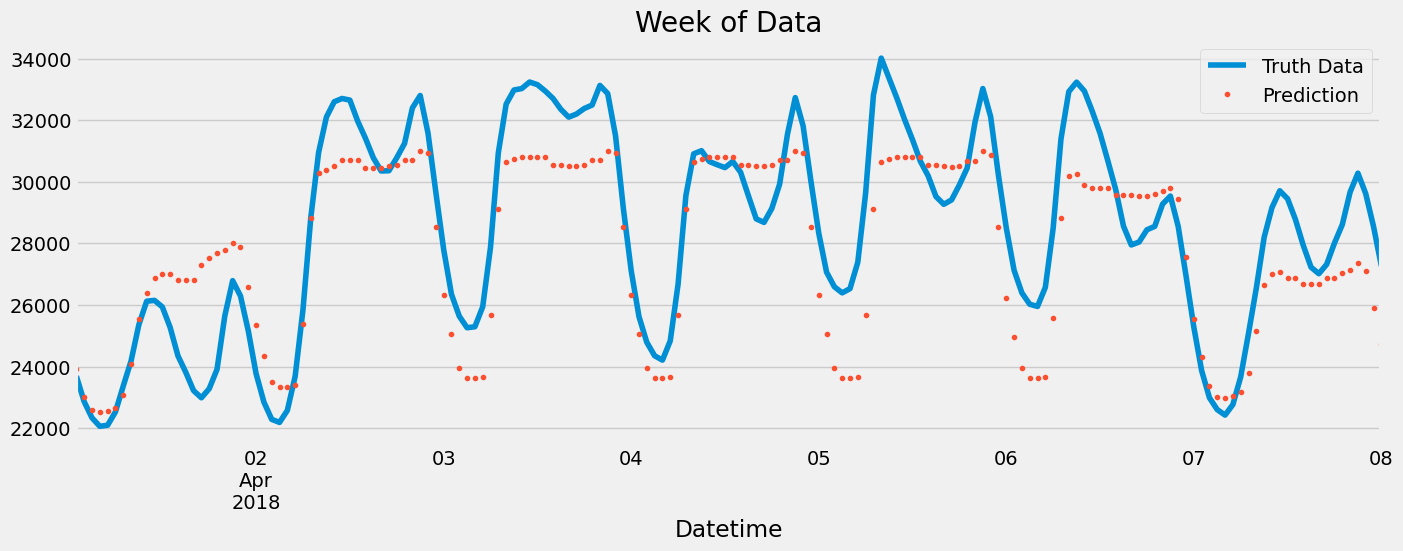

In [26]:
ax = df.loc[(df.index > '04-01-2018') & (df.index <= '04-08-2018')]['PJME_MW'].plot(figsize = (15,5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index <= '04-08-2018')]['prediction'].plot(figsize = (15,5), style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [31]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set {score:0.2f}')

RMSE Score on Test set 3732.85


##### Calculate Error

In [32]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [33]:
test['date'] = test.index.date

In [35]:
test.groupby('date')['error'].mean()

date
2015-01-01    1537.488037
2015-01-02    2647.305583
2015-01-03    1388.711182
2015-01-04    3338.918294
2015-01-05    2487.871419
                 ...     
2018-07-30    2753.121826
2018-07-31    1343.524821
2018-08-01    3394.618896
2018-08-02    3816.091878
2018-08-03    4131.132812
Name: error, Length: 1311, dtype: float64